# Effect compartment model

A 3 compartments model with an effect compartment is describd by the following linear ODE system :


\begin{align}
\frac{dy_{\mathrm{gut}}}{dt} &= -k_a y_{\mathrm{gut}} \\
\frac{dy_{\mathrm{central}}}{dt} &= k_a y_{\mathrm{gut}} - (\frac{CL}{V_{\mathrm{central}}} + \frac{Q}{V_{\mathrm{central}}}) y_{\mathrm{central}} +  \frac{Q}{V_{\mathrm{peripheral}}} y_{\mathrm{peripheral}} \\
\frac{dy_{\mathrm{peripheral}}}{dt} &= \frac{Q}{V_{\mathrm{central}}} y_{\mathrm{central}} - \frac{Q}{V_{\mathrm{peripheral}}} y_{\mathrm{peripheral}} \\
 \frac{dy_{\mathrm{effect}}}{dt} &= k_{e0} y_{\mathrm{central}} - k_{e0} y_{\mathrm{effect}}
 \end{align}


It can be transformed into matrix form and solve analyticaly.


$$ y' = \mathbf{A}y $$

 
$$ \mathbf{A} = \left[\begin{array}
{rrr}
-k_a & 0 & 0 & 0 \\
k_a & -(\frac{CL}{V_{\mathrm{cent}}} + \frac{Q}{V_{\mathrm{cent}}}) & \frac{Q}{V_{\mathrm{peri}}} & 0 \\
0 & \frac{Q}{V_{\mathrm{cent}}} & -\frac{Q}{V_{\mathrm{peri}}} & 0 \\
0 & k_{e0} & 0 & -k_{e0}
\end{array}\right] $$

The solution at time $t$ is given by 

$$y = e^{tA}y_0$$ where $e$ is the **matrix** exponential.

The effect is then computed with : $$c_e = \frac{y_{\mathrm{effect}}}{V_1} \ , \
E = \frac{100c_e}{EC_{50} + c_e} $$

We will try and compare the results obtained with a joint 2D outcome and 2 separate outcomes.

# Functions and utils

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import json
import time #to delay exectutions

import cmdstanpy
import arviz as az
az.style.use('arviz-darkgrid')
!jupyter nbextension enable --py widgetsnbextension

np.set_printoptions(suppress=True)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.39ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 2.2.1pop0-1628521831-21.10-5dbe6cf is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
cwd = os.getcwd()
stan_directory = '~/.cmdstan/cmdstan-2.29.2'

In [3]:
def plot_priors(CL, Q, VC, VP, ka) :

    fig, ax = plt.subplots(ncols=5, figsize=(10, 2))
 
    az.plot_density(CL, ax=ax[0], point_estimate='median')
    az.plot_density(Q, ax=ax[1], point_estimate='median')
    az.plot_density(VC, ax=ax[2], point_estimate='median')
    az.plot_density(VP, ax=ax[3], point_estimate='median')
    az.plot_density(ka, ax=ax[4], point_estimate='median') 

    for i in range(5) :
        ax[i].set_title(str(['CL pop', 'Q pop', 'VC pop', 'VP pop', 'ka pop'][i]))
        
    plt.show()
    
    
def plot_compare(prior_list, posterior_list, names=None) :

    fig, ax = plt.subplots(ncols=len(prior_list), figsize=(16, 4))
    
    for i in range(len(prior_list)) :
        line1 = az.plot_density(prior_list[i], ax=ax[i], point_estimate=None, colors=['blue'], shade=.3)
        line2 = az.plot_density(posterior_list[i], ax=ax[i], point_estimate=None, colors=['red'], shade=.3)
        if names is not None :
            ax[i].set_title(str(names[i]))
    plt.show()

In [4]:

def plot_ppc_mle(mle_vars, nsub, data_dir, data_prefix, t_end=192, figsize=(8, 4)) :

    with open(data_dir + '/' + data_prefix + '.data.json', 'r') as f:
      datajson = json.load(f)

    nt = datajson['nt']
    cObs = np.array(datajson['cObs'])
    effObs = np.array(datajson['effObs'])
    t = np.array(datajson['time'])
    tPK = np.array(datajson['timePK'])
    
    fig, ax = plt.subplots(nrows=2, ncols=nsub, figsize=figsize)
    
    for i in range(nsub) :

        ind = i
        start = datajson['start'][ind]-1
        end = datajson['end'][ind]
        startPK = datajson['startPK'][ind]-1
        endPK = datajson['endPK'][ind]
        
        wt = datajson['weight'][ind]

        ax[0][i].plot(t[start:end], mle_vars['cPred_ind'][start:end][0:(end-start)], '-', label='pred')
        ax[0][i].plot(tPK[startPK:endPK], cObs[startPK:endPK], 'o-', label='obs')
        ax[0][i].set_title('ind ' + str(i) + ' | weight = ' + str(np.round(wt, 1)))
        ax[0][i].legend()

        ax[1][i].plot(t[start:end], mle_vars['effPred_ind'][start:end][0:(end-start)], '-', label='pred')
        ax[1][i].plot(tPK[startPK:endPK], effObs[startPK:endPK], 'o-', label='obs')
        ax[1][i].legend()

        
    
def plot_ppc_az(az_chains, nsub, figsize=(10, 2)) :
 
    cPred_ind = az_chains.posterior_predictive['cPred_ind']
    cPred_pop = az_chains.posterior_predictive['cPred_pop']
    effPred_ind = az_chains.posterior_predictive['effPred_ind']
    effPred_pop = az_chains.posterior_predictive['effPred_pop']
    t = az_chains.observed_data['time']
    tPK = az_chains.observed_data['timePK']

    fig, ax = plt.subplots(nrows=2, ncols=nsub, figsize=figsize) 

    for i in range(nsub) :

        wt = np.array(az_chains.observed_data['weight'][i])
        PKstart = int(az_chains.observed_data['startPK'][i]-1)
        PKend = int(az_chains.observed_data['endPK'][i])
        start = int(az_chains.observed_data['start'][i]-1)
        end = int(az_chains.observed_data['end'][i])

        
        cPred_ind_i = cPred_ind[:, :, start:end]
        c_qlow_ind = np.quantile(cPred_ind_i, 0.05, axis=[0,1])
        c_qhigh_ind = np.quantile(cPred_ind_i, 0.975, axis=[0,1])
        
        cPred_pop_i = cPred_pop[:, :, start:end]
        c_qlow_pop = np.quantile(cPred_pop_i, 0.05, axis=[0,1])
        c_qhigh_pop = np.quantile(cPred_pop_i, 0.975, axis=[0,1])

        ax[0][i].plot(t[start:end], cPred_ind_i.mean(axis=0).mean(axis=0),
                   color='red', label='ind pred') 
        ax[0][i].fill_between(t[start:end], 
                              c_qlow_ind[0:(end-start)], 
                              c_qhigh_ind[0:(end-start)], 
                              alpha=0.2, color='red', label='95% CI')
        
        ax[0][i].plot(t[start:end], cPred_pop_i.mean(axis=0).mean(axis=0),
                   color='blue', label='pop pred') 
        ax[0][i].fill_between(t[start:end], 
                              c_qlow_pop[0:(end-start)], 
                              c_qhigh_pop[0:(end-start)], 
                              alpha=0.2, color='blue', label='95% CI')
        
        ax[0][i].plot(tPK[PKstart:PKend], az_chains.observed_data['cObs'][PKstart:PKend], 
                   '-o', markersize=3, color='black', label='obs')
        

        ax[0][i].set_title('ind ' + str(i+1) + ' | weight = ' + str(np.round(wt, 1)))

   
        effPred_ind_i = effPred_ind[:, :, start:end]
        eff_qlow_ind = np.quantile(effPred_ind_i, 0.05, axis=[0,1])
        eff_qhigh_ind = np.quantile(effPred_ind_i, 0.975, axis=[0,1])
        
        effPred_pop_i = effPred_pop[:, :, start:end]
        eff_qlow_pop = np.quantile(effPred_pop_i, 0.05, axis=[0,1])
        eff_qhigh_pop = np.quantile(effPred_pop_i, 0.975, axis=[0,1])

        ax[1][i].plot(t[start:end], effPred_ind_i.mean(axis=0).mean(axis=0), 
                      color='red', label='ind pred')   
        ax[1][i].fill_between(t[start:end], 
                              eff_qlow_ind, 
                              eff_qhigh_ind, 
                              alpha=0.2, color='red', label='95% CI')

        ax[1][i].plot(t[start:end], effPred_pop_i.mean(axis=0).mean(axis=0), 
                      color='blue', label='pop pred')   
        ax[1][i].fill_between(t[start:end], 
                              eff_qlow_pop, 
                              eff_qhigh_pop, 
                              alpha=0.2, color='blue', label='95% CI')
        
        ax[1][i].plot(tPK[PKstart:PKend], az_chains.observed_data['effObs'][PKstart:PKend],
                     '-o', markersize=3, color='black', label='obs')

    ax[0][0].set_ylabel('Concentration')
    ax[1][0].set_ylabel('Response')
    ax[0][0].legend()
    
    plt.show()

In [5]:
data_dir = 'data/'
data_prefix = 'EffectData_5sub'
data_file = data_prefix + '.data.R'
init_file = data_prefix + '.init.R'
#! cat $data_dir/$init_file

# 1. Not joint outcome

## MLE

In [237]:
model = 'not_joint'
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [238]:
mle_fit = mle_model.optimize(data=data_dir + data_file, inits=data_dir + init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [239]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'][0:4], mle['ka_pop'], mle['sigma_c'])
print(mle['THETA_pop'][4], mle['EC50_pop'], mle['sigma_eff'])

[ 10.307   17.1309  46.5034 101.446 ] 2.16137 0.0955058
1.47098 116.449 0.0653217


### Posterior checks

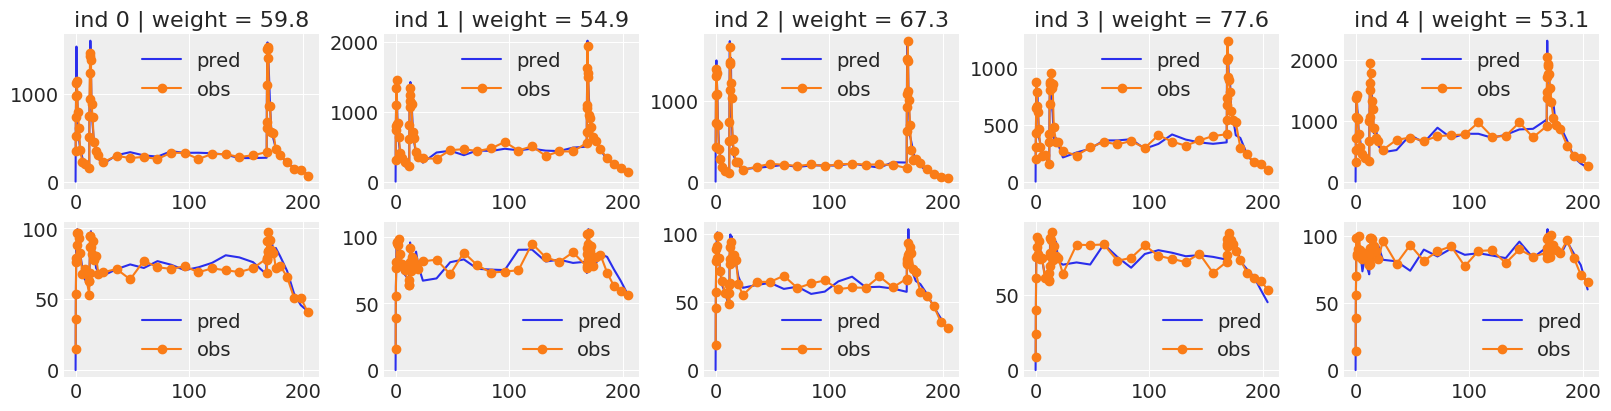

In [240]:
plot_ppc_mle(mle, 5, data_dir, data_prefix, figsize=(16, 4))

## HMC

In [225]:
model = 'not_joint'
hmc_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [226]:
fit_foldername="output_hmc_" + model + '_5sub'
fit_filename="output_hmc_" + model 
output_dir= cwd + "/" + fit_foldername
! mkdir -p $output_dir

In [172]:
#! rm $output_dir/*
hmc_fit = hmc_model.sample(data=data_dir + data_file, inits=data_dir + init_file,
                        chains=2, iter_warmup=1000, iter_sampling=500, save_warmup=0, 
                        show_progress=True, output_dir=output_dir)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [174]:
hmc_fit.summary().head(8)

Mean    MCSE  StdDev      5%     50%     95%   N_Eff  N_Eff/s  \
name                                                                        
lp__      1100.0  0.3400   6.000  1100.0  1100.0  1100.0   310.0    0.087   
CL_pop      11.0  0.0950   1.700     8.1    10.0    14.0   330.0    0.091   
Q_pop       18.0  0.0900   2.400    14.0    17.0    21.0   700.0    0.190   
VC_pop      49.0  0.3400   8.600    36.0    48.0    63.0   630.0    0.170   
VP_pop     100.0  0.3800   9.100    88.0   100.0   120.0   580.0    0.160   
ke0_pop      1.5  0.0030   0.076     1.4     1.5     1.6   630.0    0.170   
ka_pop       2.2  0.0036   0.150     1.9     2.2     2.4  1700.0    0.470   
EC50_pop   120.0  0.0580   2.200   110.0   120.0   120.0  1400.0    0.390   

          R_hat  
name             
lp__        1.0  
CL_pop      1.0  
Q_pop       1.0  
VC_pop      1.0  
VP_pop      1.0  
ke0_pop     1.0  
ka_pop      1.0  
EC50_pop    1.0

In [183]:
chains = az.from_cmdstan(output_dir + '/*' + '.csv', 
                         observed_data= data_dir + '/' + data_file,
                         posterior_predictive=['cPred_pop', 'cPred_ind', 'effPred_pop', 'effPred_ind'])
chains

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

### Posterior distribution of parameters

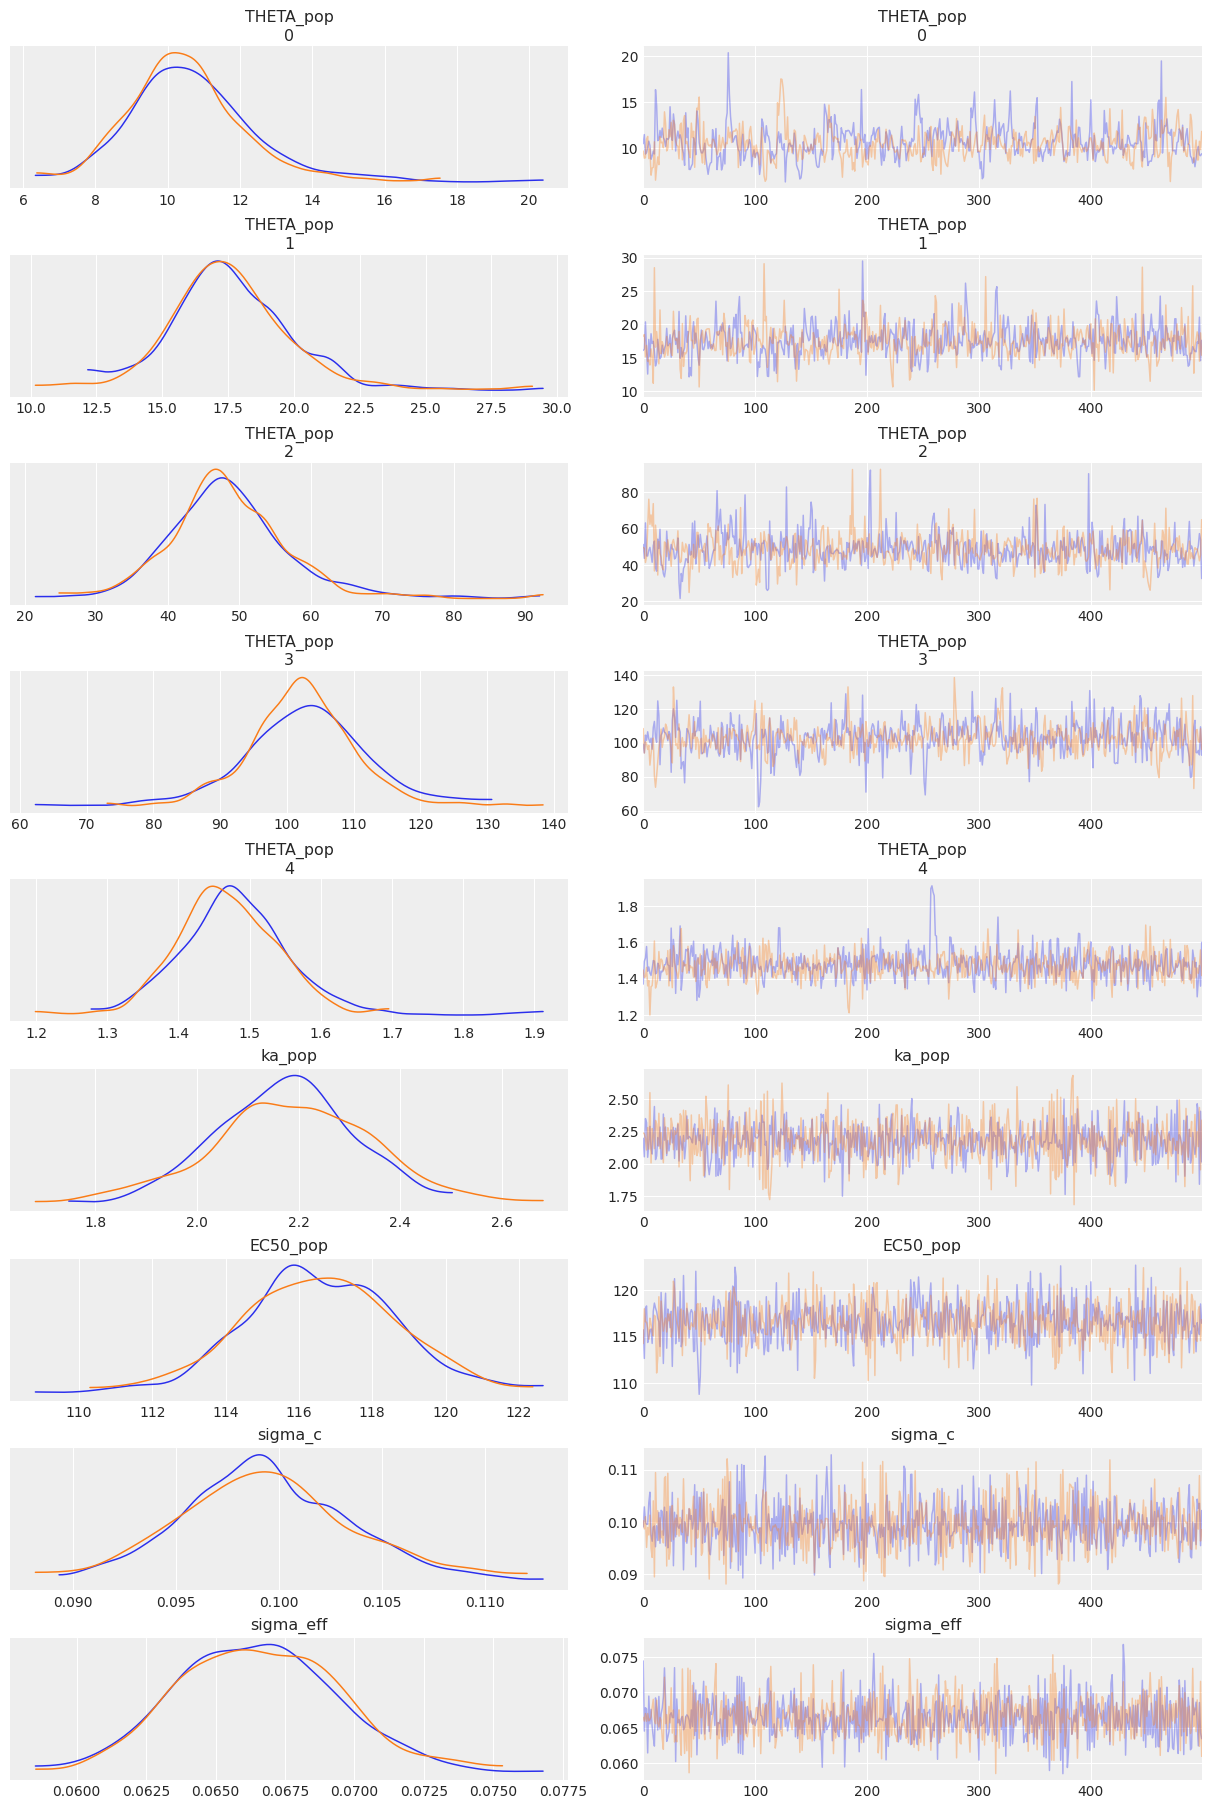

In [184]:
az.plot_trace(chains.posterior, var_names=['THETA_pop', 'ka_pop', 'EC50_pop', 'sigma_c', 'sigma_eff'], compact=False) ;

### Pair plot of posterior parameters draws

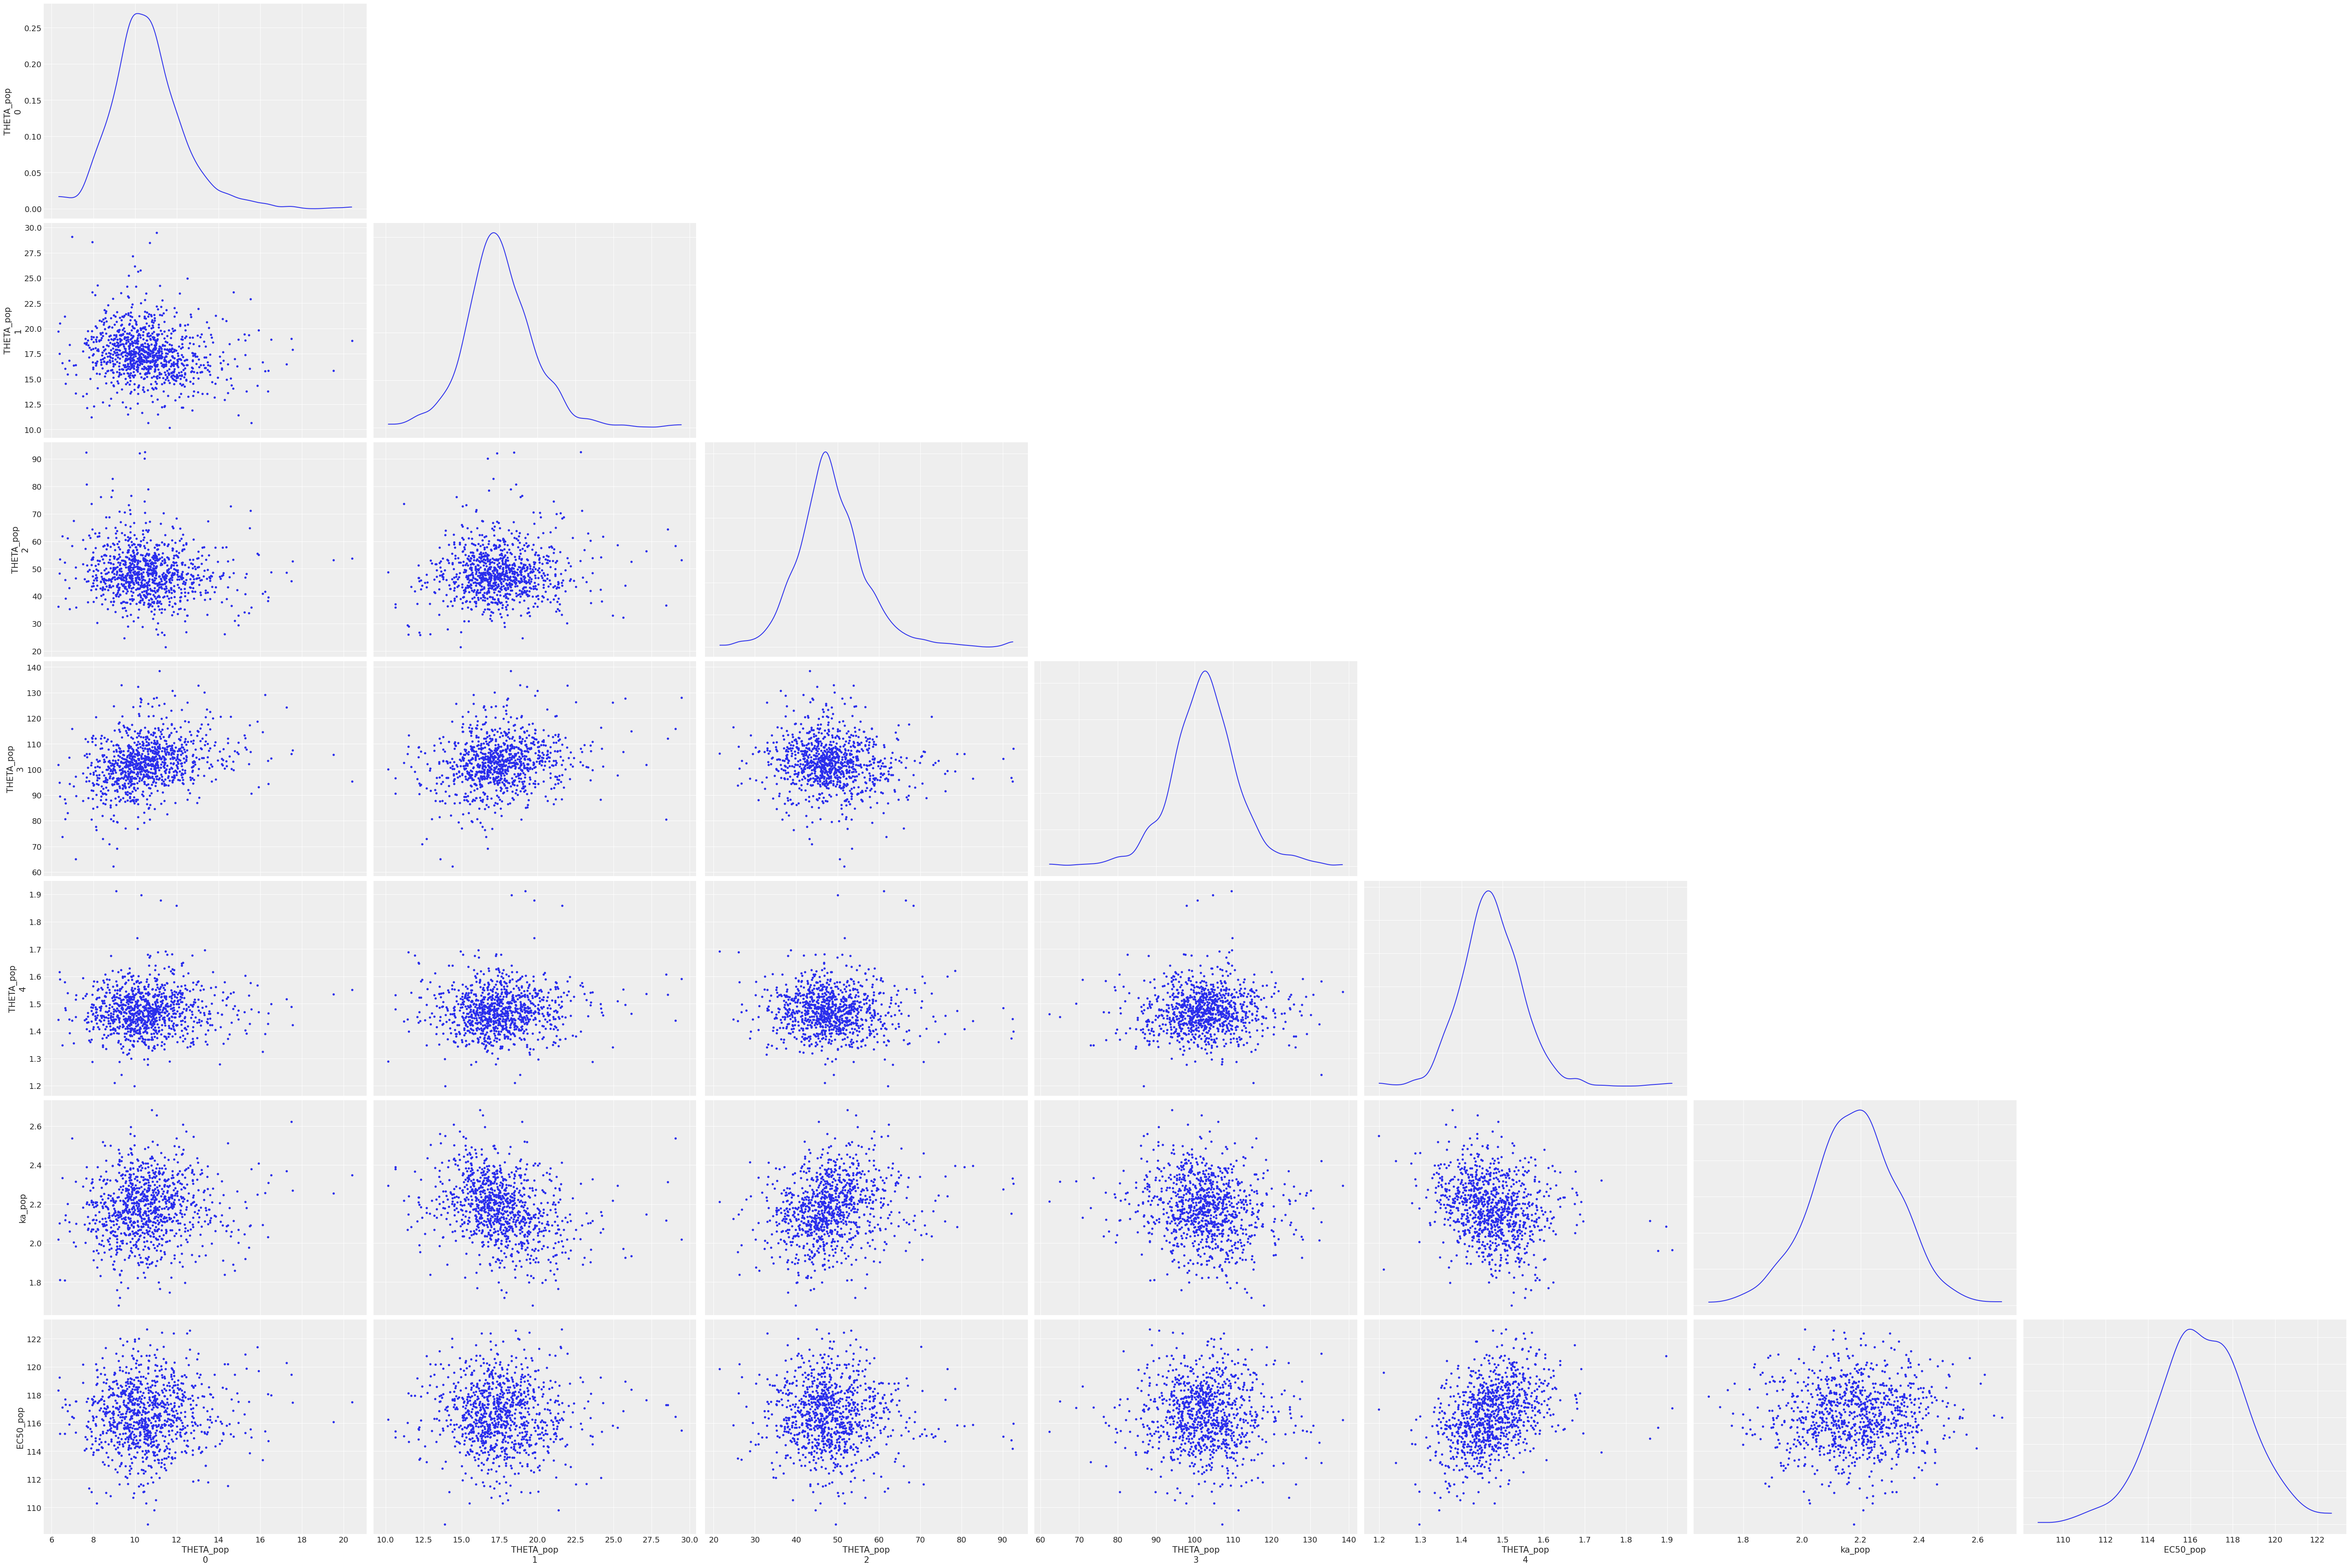

In [206]:
az.plot_pair(chains, var_names=['THETA_pop', 'ka_pop', 'EC50_pop'], marginals=True) ;

### Posterior predictive checks

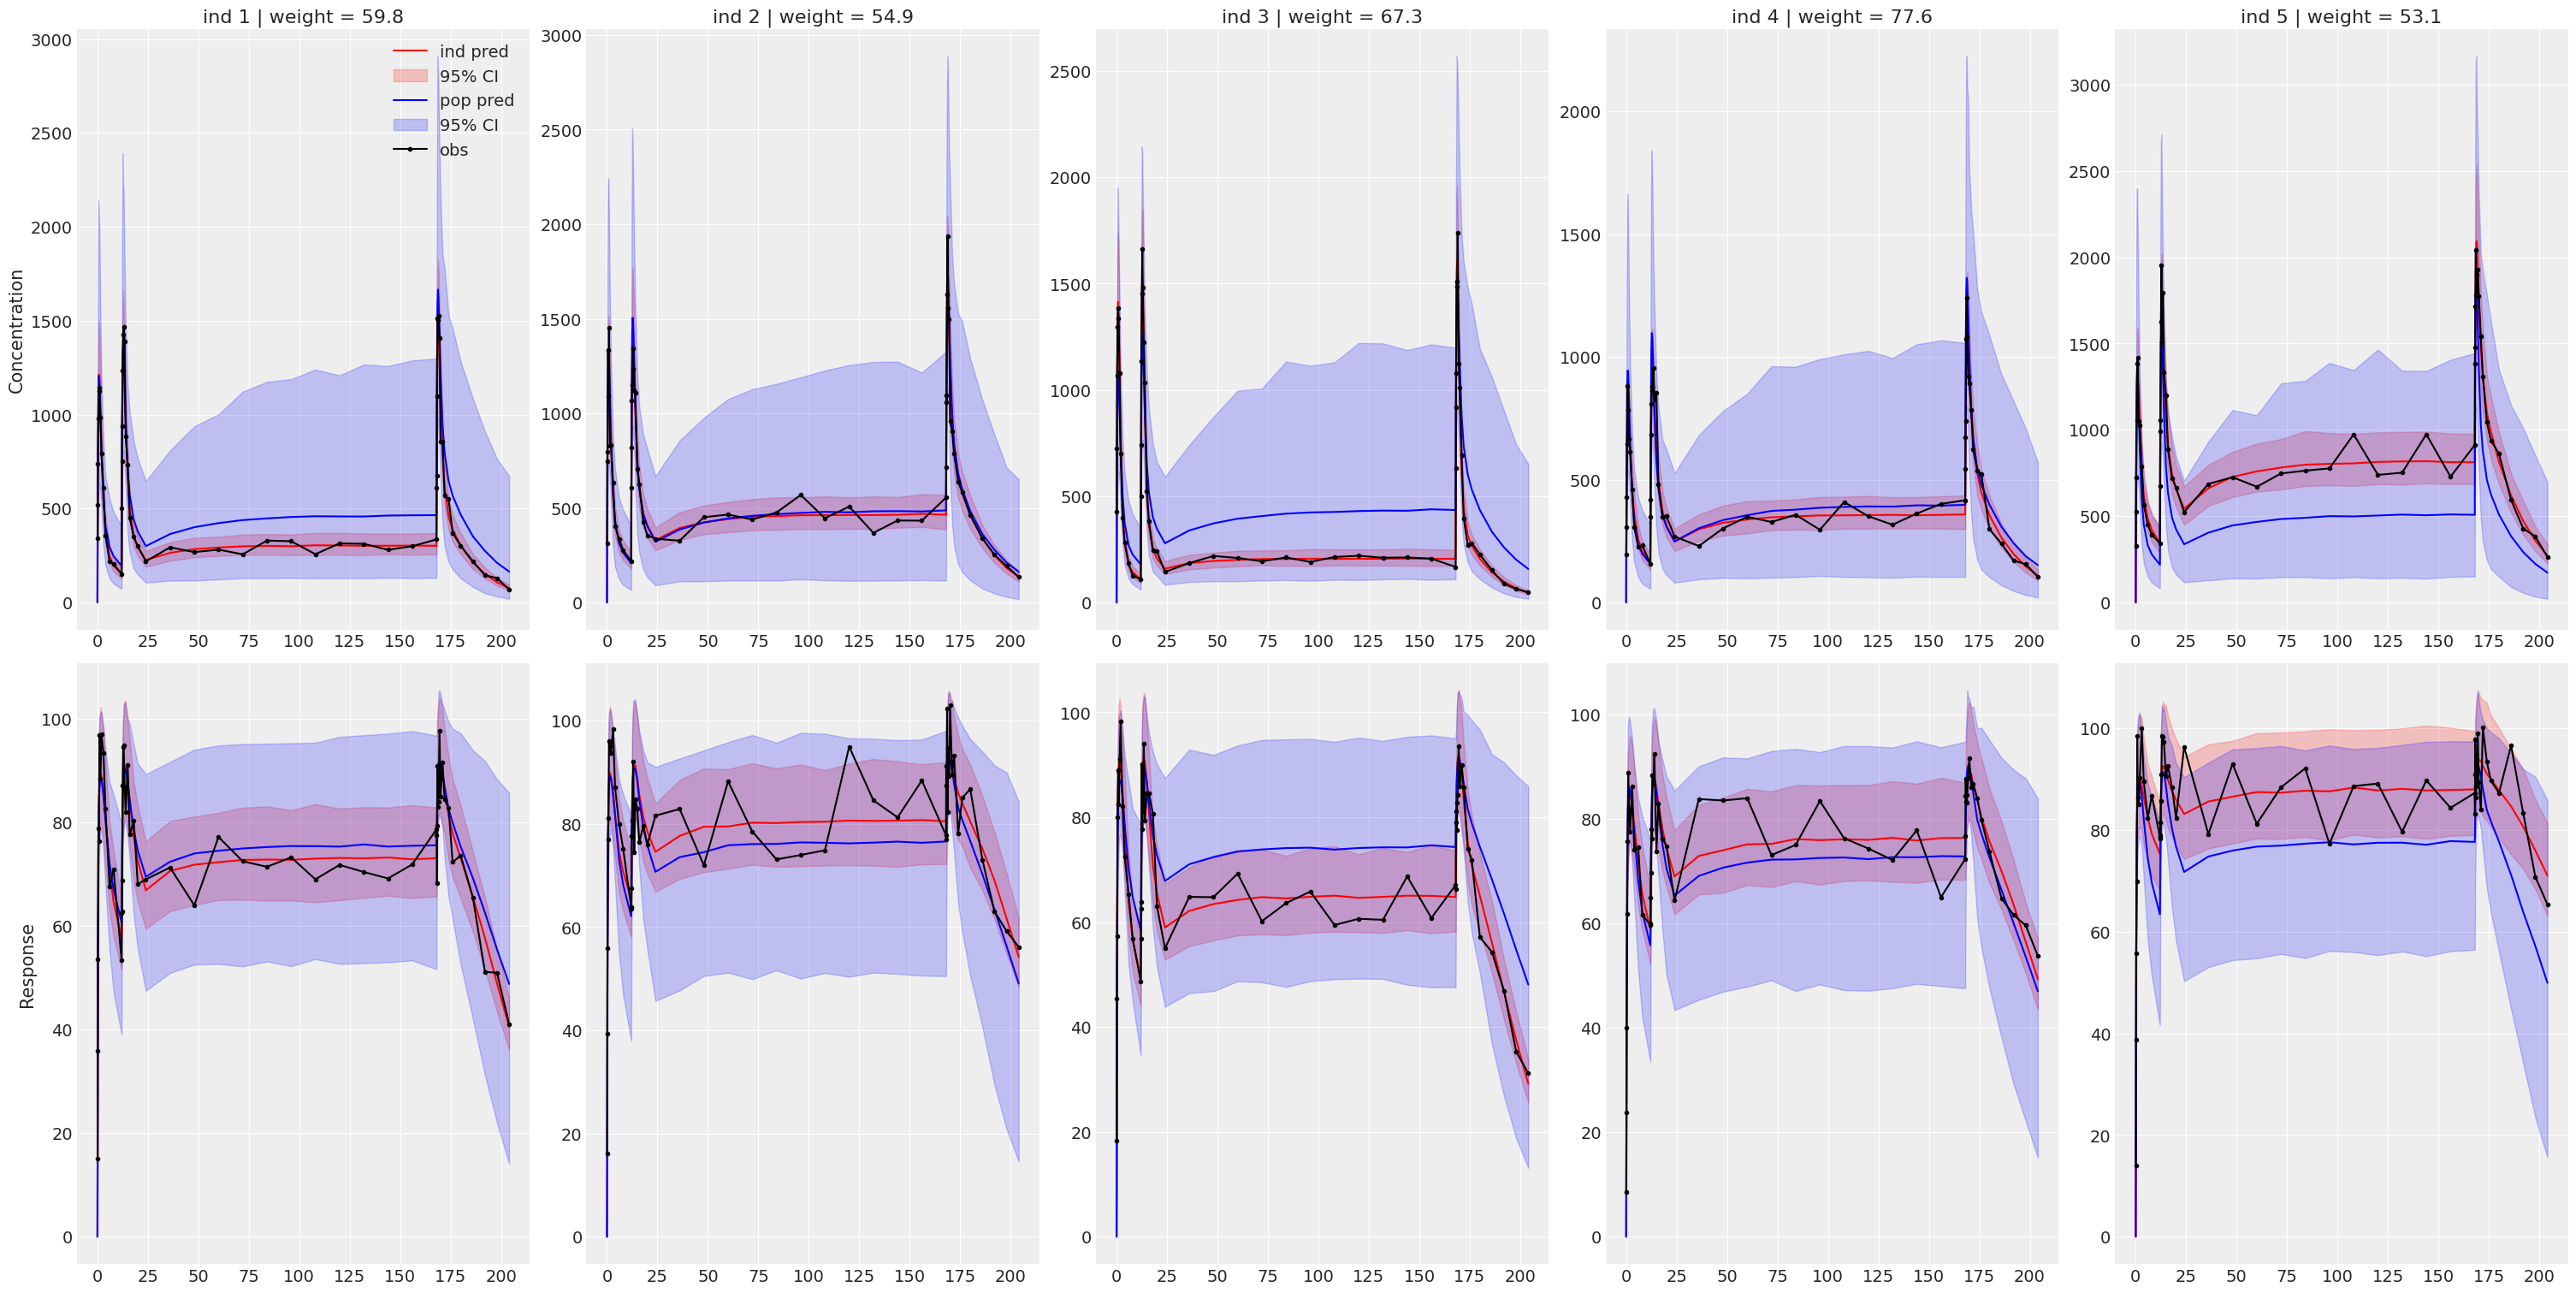

In [208]:
plot_ppc_az(chains, 5, figsize=(30, 15))

### Comparison of prior and posterior parameters distributions

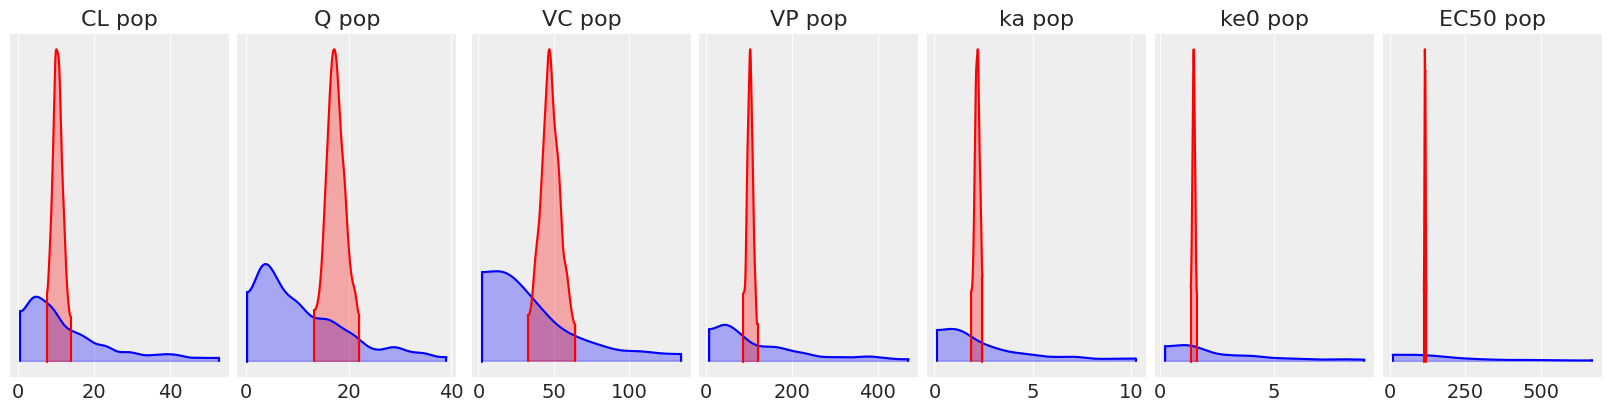

In [205]:
CLpop_prior = np.random.lognormal(mean=np.log(10), sigma=1, size=500)
Qpop_prior = np.random.lognormal(mean=np.log(10), sigma=1, size=500)
VCpop_prior = np.random.lognormal(mean=np.log(30), sigma=1, size=500)
VPpop_prior = np.random.lognormal(mean=np.log(100), sigma=1, size=500)
kapop_prior = np.random.lognormal(mean=np.log(2), sigma=1, size=500)
ke0pop_prior = np.random.lognormal(mean=np.log(2), sigma=1, size=500)
EC50pop_prior = np.random.lognormal(mean=np.log(150), sigma=1, size=500)

prior = [CLpop_prior, Qpop_prior, VCpop_prior, VPpop_prior, kapop_prior, ke0pop_prior, EC50pop_prior]
post_PK = [chains.posterior['THETA_pop'][:, :, i].values for i in range(4)]
post = [0] * 7
post[0:4] = post_PK
post[4] = chains.posterior['ka_pop'].values
post[5] = chains.posterior['THETA_pop'][:, :, 4].values
post[6] = chains.posterior['EC50_pop'].values

plot_compare(prior, post, names=['CL pop', 'Q pop', 'VC pop', 'VP pop', 'ka pop', 'ke0 pop', 'EC50 pop'])

# 2. Joint outcome

In [9]:
model = 'joint'
mle_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [10]:
mle_fit = mle_model.optimize(data=data_dir + data_file, inits=data_dir + init_file)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
mle = mle_fit.stan_variables()
print(mle['THETA_pop'][0:4], mle['ka_pop'])
print(mle['THETA_pop'][4], mle['EC50_pop'])

[ 10.3093  17.0887  46.7069 101.222 ] 2.17338
1.47002 116.413


The estimated parameters are the same as without joint output covariance.

In [12]:
mle['Omega_out']

array([[ 0.00916719, -0.00044122],
       [-0.00044122,  0.00426836]])

The variance for the effect is 0.002 smaller. The variance for the concentration stays the same.

In [14]:
mle['R_out']

array([[ 1.       , -0.0705354],
       [-0.0705354,  1.       ]])

Stan does not highlight the correlation between the two output variables.

### Posterior checks

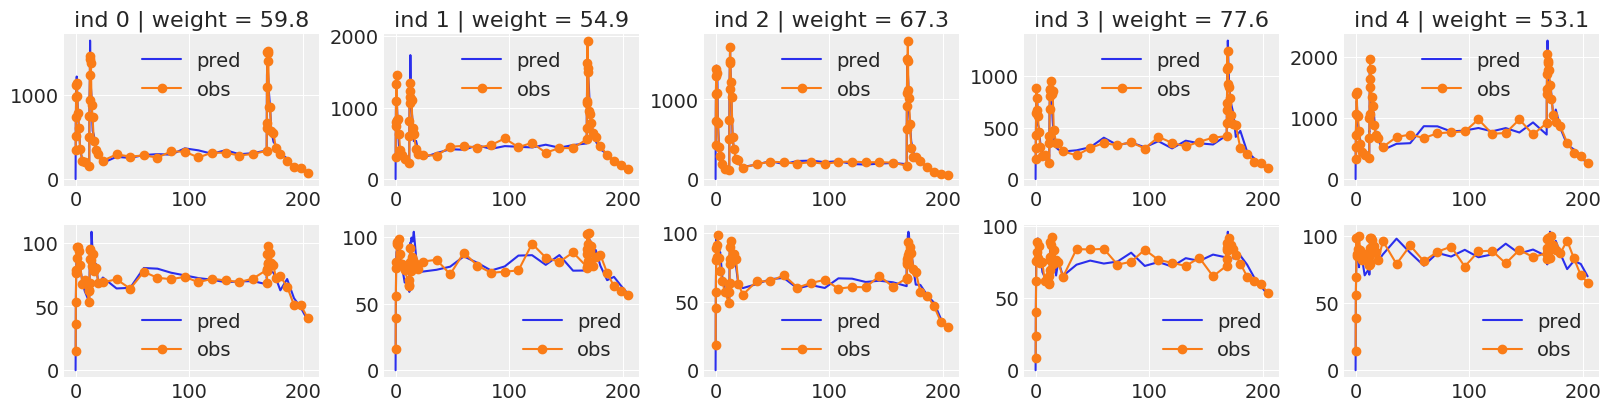

In [15]:
plot_ppc_mle(mle, 5, data_dir, data_prefix, figsize=(16, 4))

## HMC

In [16]:
model = 'joint'
hmc_model = cmdstanpy.CmdStanModel(model_name=model, stan_file='model/' + model + '.stan') 

INFO:cmdstanpy:found newer exe file, not recompiling


In [17]:
fit_foldername="output_hmc_" + model + '_5sub'
fit_filename="output_hmc_" + model 
output_dir= cwd + "/" + fit_foldername
! mkdir -p $output_dir

In [18]:
#! rm $output_dir/*
hmc_fit = hmc_model.sample(data=data_dir + data_file, inits=data_dir + init_file,
                        chains=2, iter_warmup=2000, iter_sampling=500, save_warmup=0, 
                        show_progress=True, output_dir=output_dir)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [19]:
hmc_fit.summary().head(8)

Mean    MCSE  StdDev      5%     50%     95%   N_Eff  N_Eff/s  \
name                                                                        
lp__      1100.0  0.3500   6.100  1100.0  1100.0  1100.0   310.0     0.19   
CL_pop      11.0  0.1100   1.900     8.3    10.0    14.0   280.0     0.17   
Q_pop       17.0  0.1000   2.300    14.0    17.0    22.0   540.0     0.33   
VC_pop      49.0  0.3600   8.900    37.0    48.0    63.0   600.0     0.37   
VP_pop     100.0  0.3700   9.300    88.0   100.0   120.0   620.0     0.38   
ke0_pop      1.5  0.0026   0.077     1.4     1.5     1.6   850.0     0.52   
ka_pop       2.2  0.0035   0.140     1.9     2.2     2.4  1600.0     0.98   
EC50_pop   120.0  0.0580   2.300   110.0   120.0   120.0  1500.0     0.95   

          R_hat  
name             
lp__        1.0  
CL_pop      1.0  
Q_pop       1.0  
VC_pop      1.0  
VP_pop      1.0  
ke0_pop     1.0  
ka_pop      1.0  
EC50_pop    1.0

In [20]:
chains = az.from_cmdstan(output_dir + '/*' + '.csv', 
                         observed_data= data_dir + '/' + data_file,
                         posterior_predictive=['cPred_pop', 'cPred_ind', 'effPred_pop', 'effPred_ind'])
chains

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

### Posterior distribution of the parameters

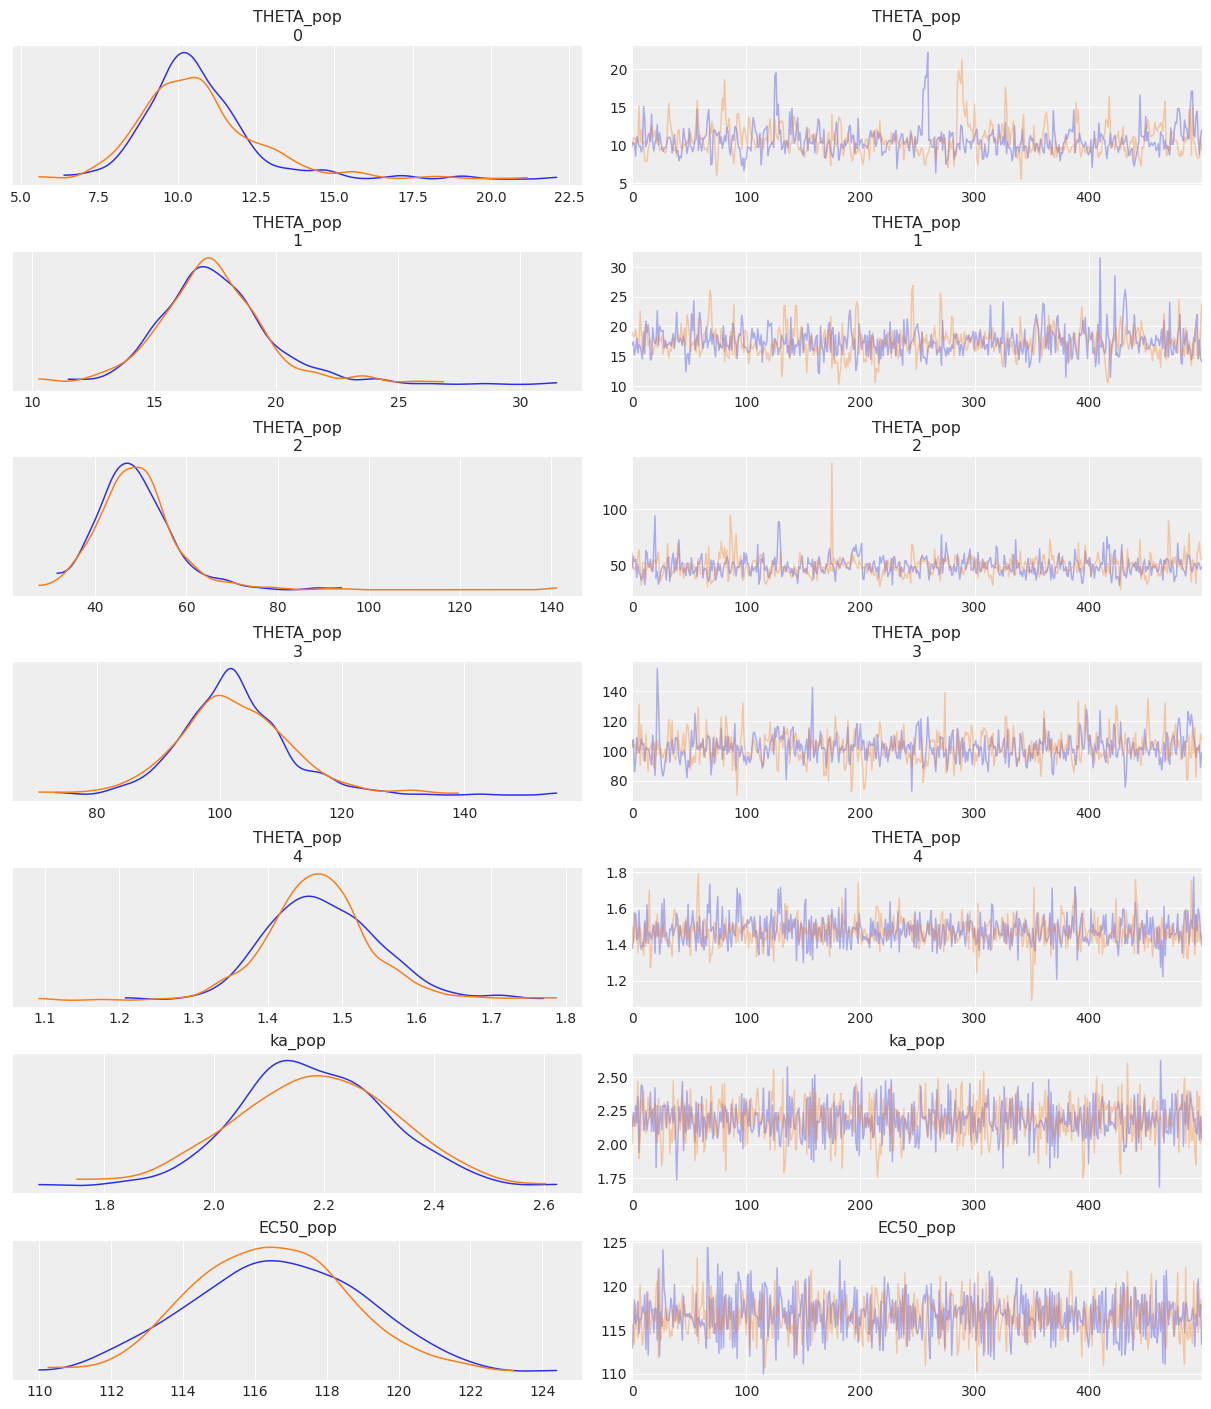

In [21]:
az.plot_trace(chains.posterior, var_names=['THETA_pop', 'ka_pop', 'EC50_pop'], compact=False) ;

### Pair plots of posterior parameters draws

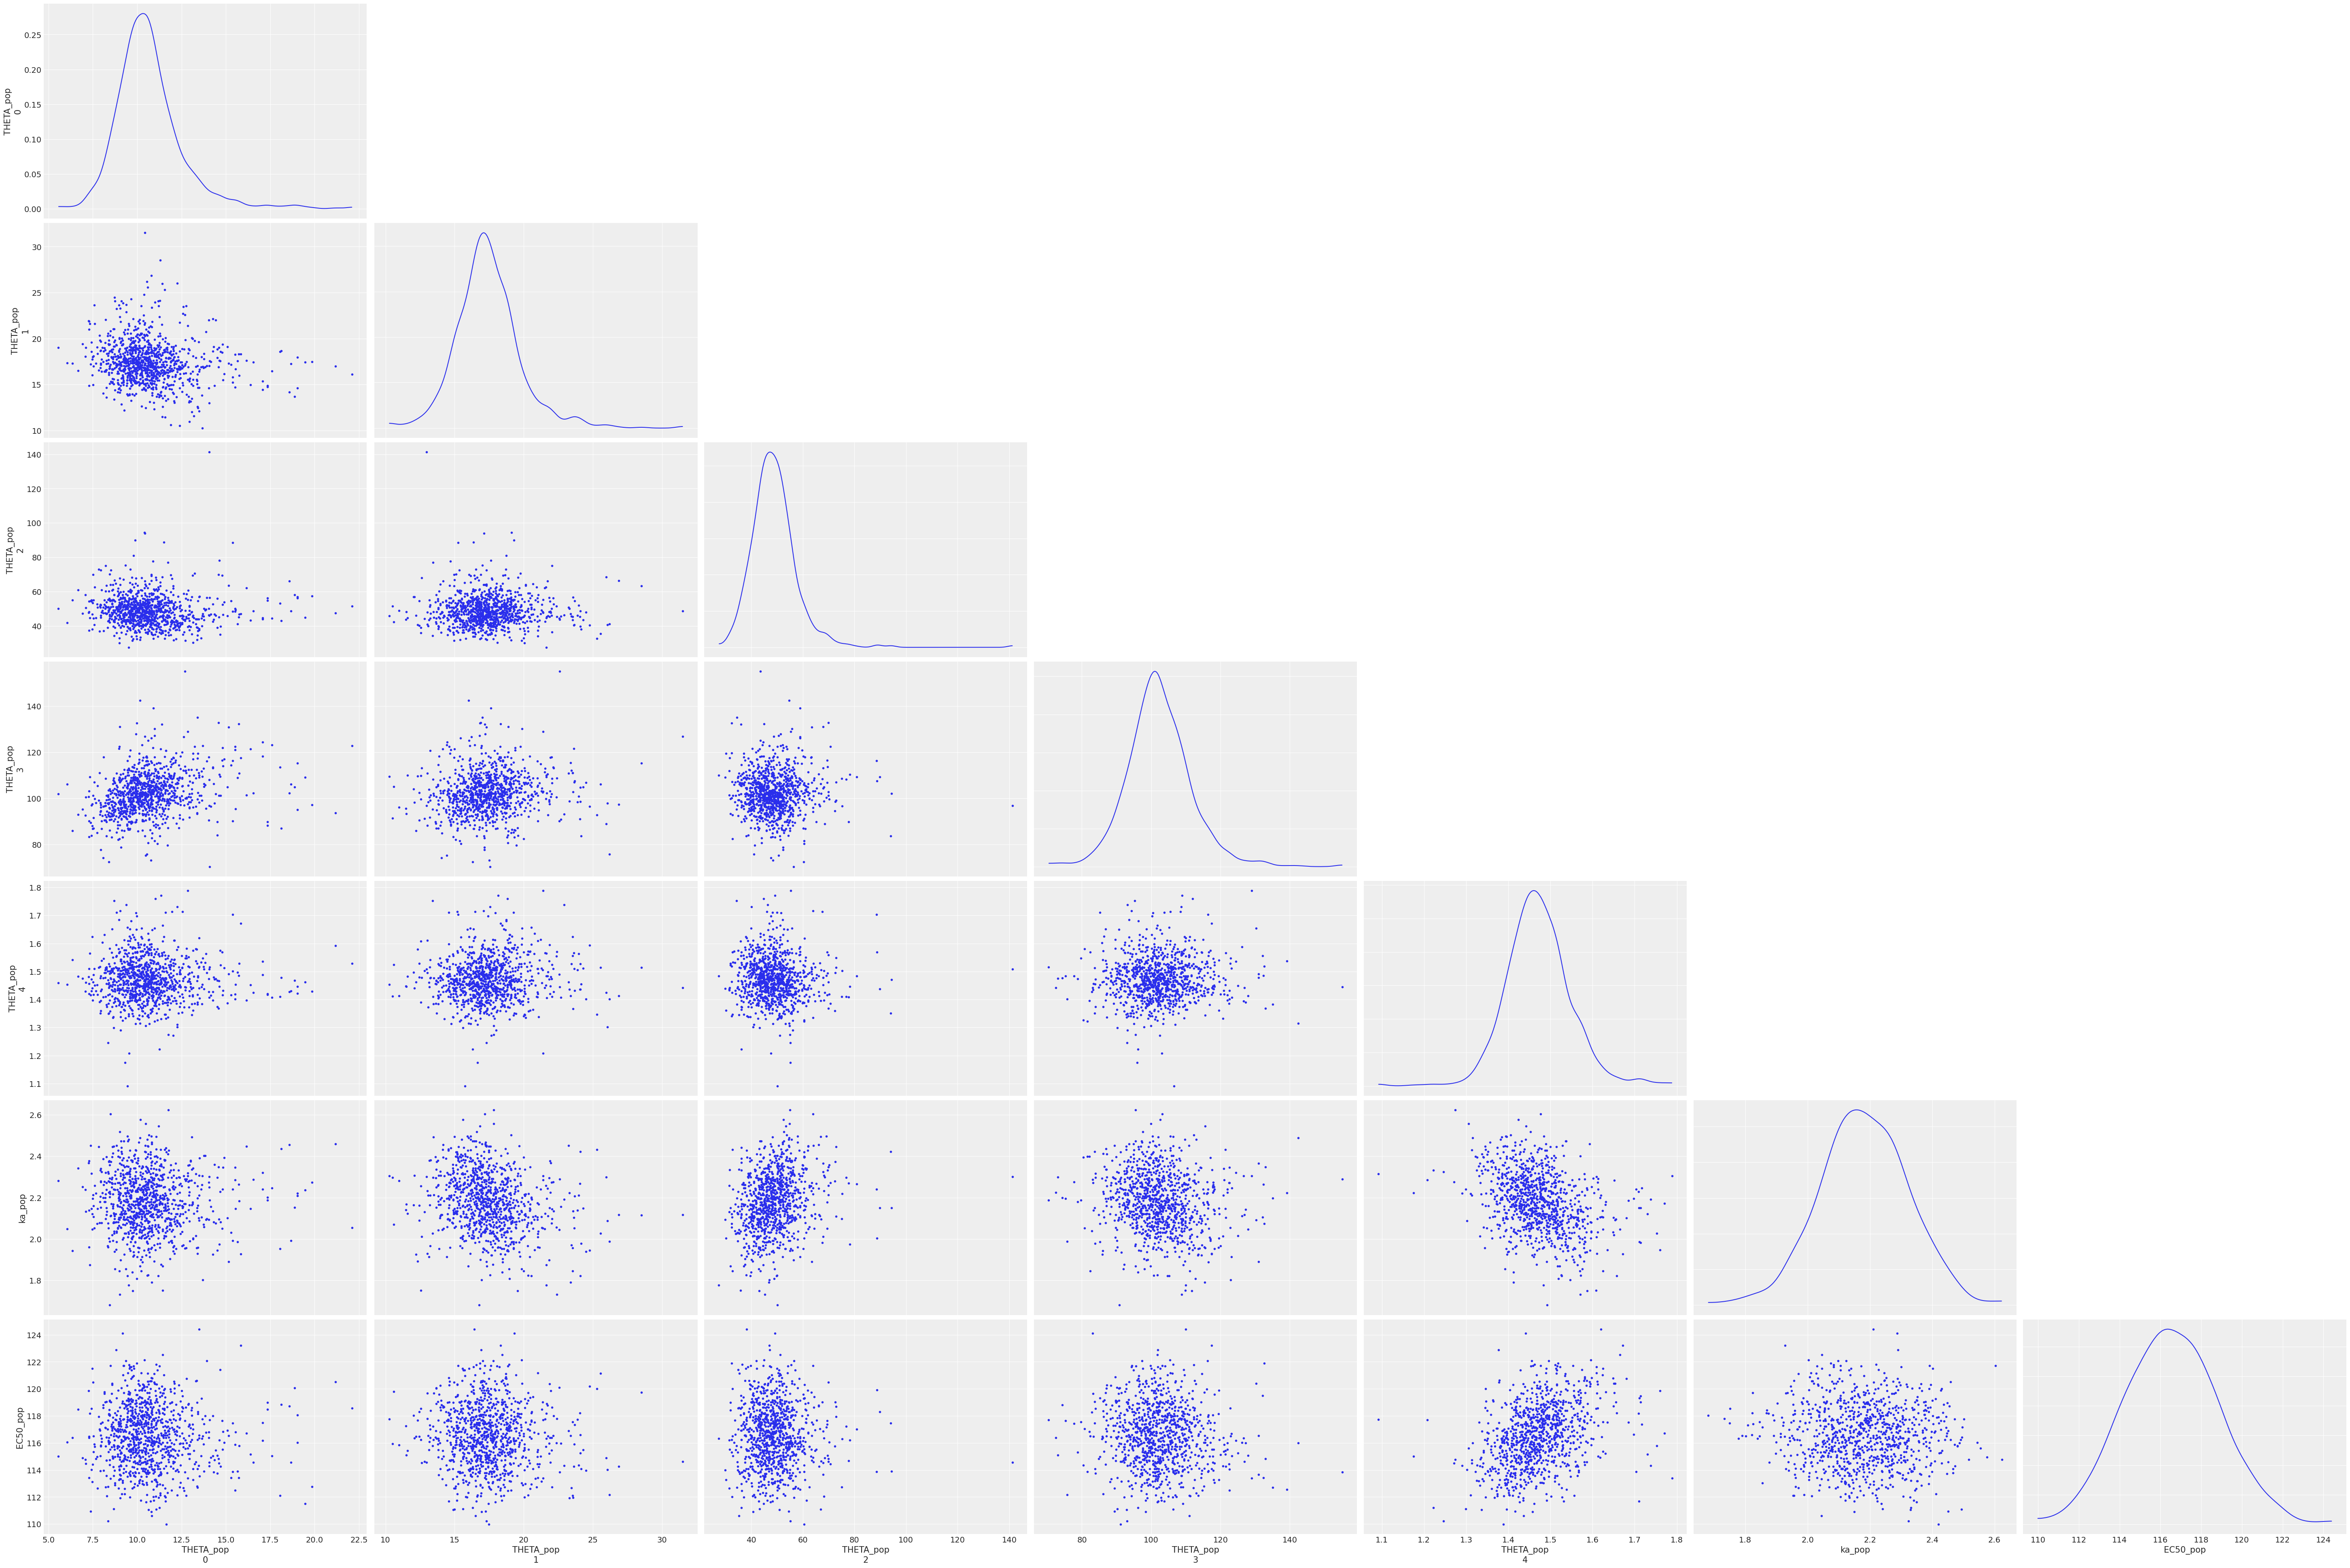

In [22]:
az.plot_pair(chains, var_names=['THETA_pop', 'ka_pop', 'EC50_pop'], marginals=True) ;

### Joint covariance related outputs

In [23]:
chains.posterior['Omega_out'].mean(axis=0).mean(axis=0).values

array([[ 0.00995277, -0.00032197],
       [-0.00032197,  0.00444586]])

In [24]:
chains.posterior['R_out'].mean(axis=0).mean(axis=0).values

array([[ 1.       , -0.0479752],
       [-0.0479752,  1.       ]])

### Postorior predictive checks

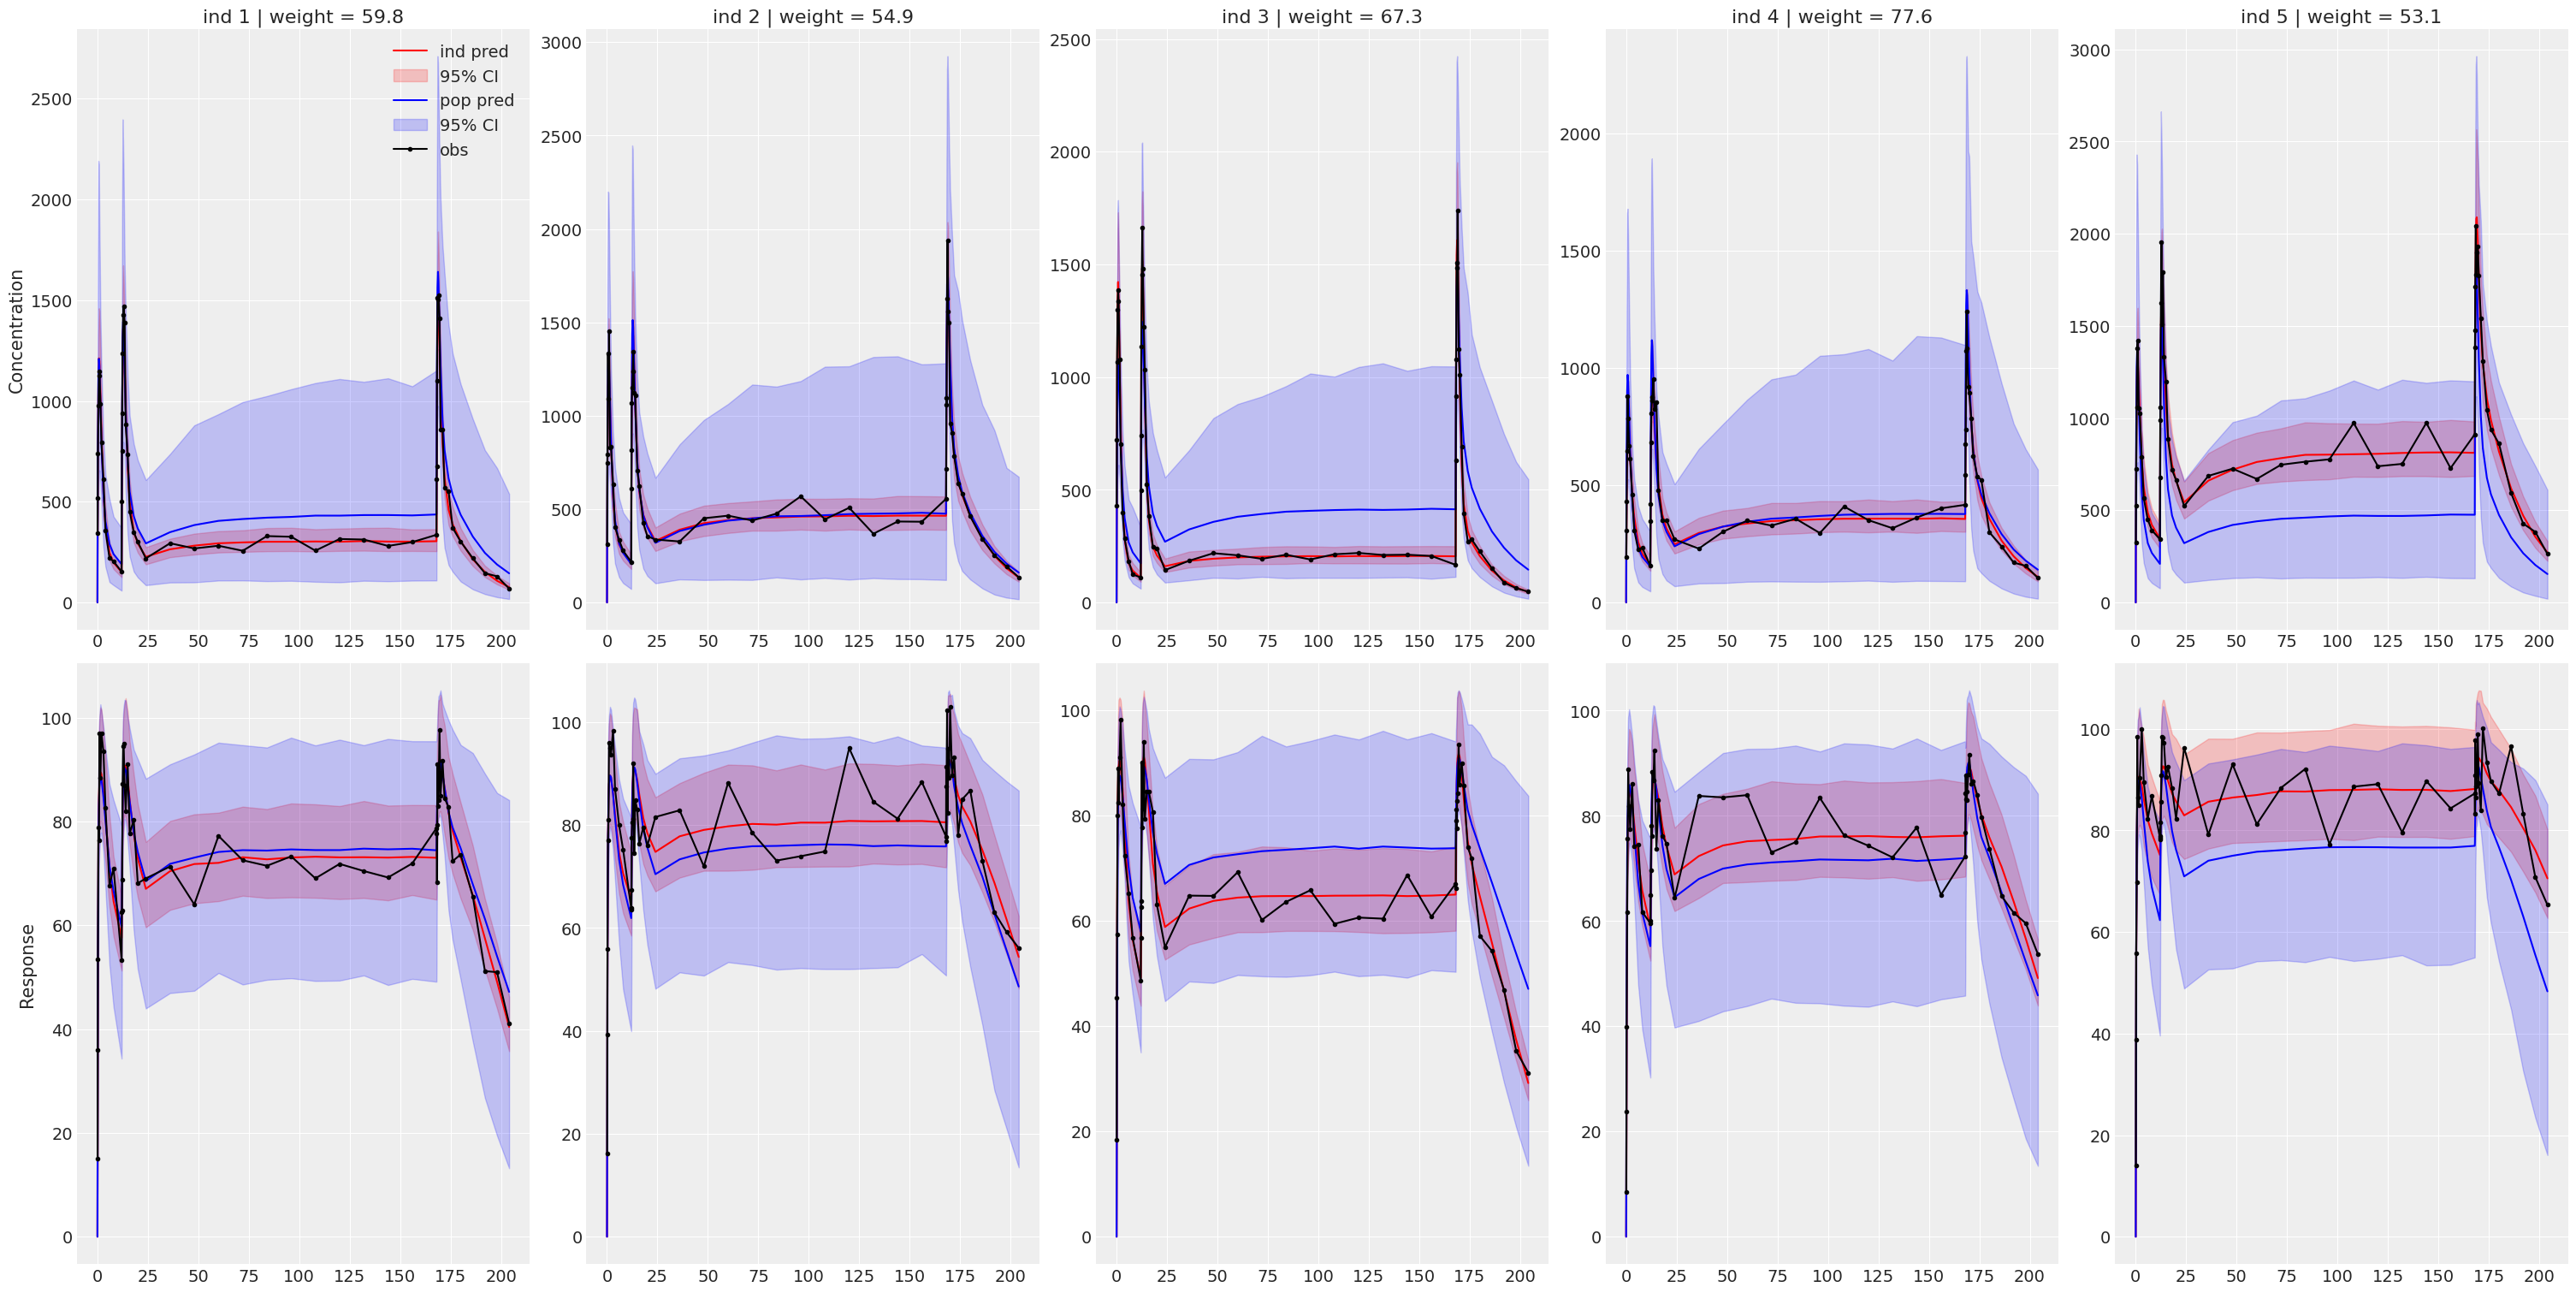

In [25]:
plot_ppc_az(chains, 5, figsize=(30, 15))

### Comparison of prior and posterior parameters distributions

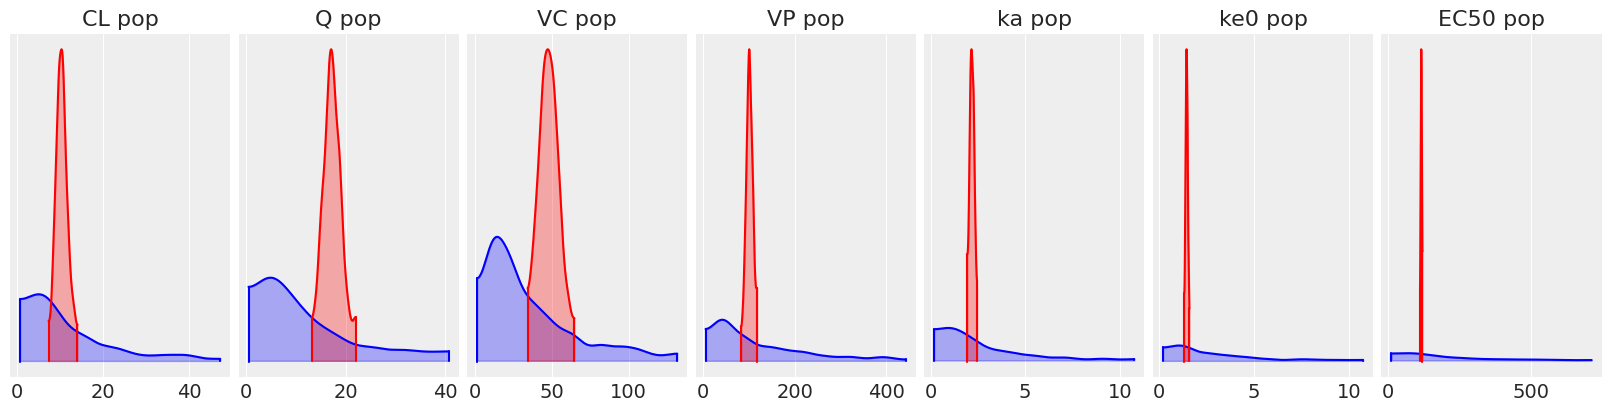

In [26]:
CLpop_prior = np.random.lognormal(mean=np.log(10), sigma=1, size=500)
Qpop_prior = np.random.lognormal(mean=np.log(10), sigma=1, size=500)
VCpop_prior = np.random.lognormal(mean=np.log(30), sigma=1, size=500)
VPpop_prior = np.random.lognormal(mean=np.log(100), sigma=1, size=500)
kapop_prior = np.random.lognormal(mean=np.log(2), sigma=1, size=500)
ke0pop_prior = np.random.lognormal(mean=np.log(2), sigma=1, size=500)
EC50pop_prior = np.random.lognormal(mean=np.log(150), sigma=1, size=500)

prior = [CLpop_prior, Qpop_prior, VCpop_prior, VPpop_prior, kapop_prior, ke0pop_prior, EC50pop_prior]
post_PK = [chains.posterior['THETA_pop'][:, :, i].values for i in range(4)]
post = [0] * 7
post[0:4] = post_PK
post[4] = chains.posterior['ka_pop'].values
post[5] = chains.posterior['THETA_pop'][:, :, 4].values
post[6] = chains.posterior['EC50_pop'].values

plot_compare(prior, post, names=['CL pop', 'Q pop', 'VC pop', 'VP pop', 'ka pop', 'ke0 pop', 'EC50 pop'])